# Black Scholes Model Deep Calibration - learning iv

Kommentare und Erläuterungen folgen.
Code soweit funktionsfähig.

In [314]:
# Libraries laden
import numpy as np
from math import log, sqrt, exp
from scipy import stats
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [315]:
# Function that equals R's expand_grid
import itertools
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [316]:
# Generate sznthetic data
synthetic_data = expand_grid({
    'stock_price': np.arange(40, 61),
    'strike_price':np.arange(20, 90),
    'maturity': np.arange(3/12, 2, step = 1/12),
    'risk_free_rate':np.arange(0.01, 0.06, step = 0.01),
    'sigma': np.arange(0.1, 0.9, step = 0.1)
}
)

In [317]:
# Black-Scholes Modell zur Berechnung der IV
def bs_option_value(S0, K, T, r, sigma):
    'Function to calculate the value of a call option based on the Black-Scholes formula'
    'arguments:'
    'S0: inital stock price'
    'K: strike price'
    'T: maturity'
    'r: risk free rate (constant)'
    'sigma: volatility'
    'returns: option value'
    #calculate d1 and d2
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    d2 = ((np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T)))
    option_value = S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0)
    return option_value

In [318]:
# Testing the function
bs_option_value(1,2,4,3,5)

0.9999999988919036

In [319]:
# calculate option vega
def option_vega(S0, K, T, r, sigma):
    'takes the same arguments as the function above'
    'returns option vega'
    d1 = ((np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T)))
    vega = S0 * stats.norm.cdf(d1, 0.0, 1.0) * np.sqrt(T)
    return vega

In [320]:
# Testing the function
option_vega(1,2,3,4,5)

1.7320507924724615

In [321]:
# calculate implied volatility
def implied_volatility(S0, K, T, C0, r, sigma):
    'calculates the implied volatility'
    'C0: call price'
    'retunts implied volatility'
    d1 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    fx = S0 * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0) - C0
    
    vega = (1 / np.sqrt(2 * np.pi)) * S0 * np.sqrt(T) * np.exp(-(stats.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    # Warum hier andere Formal fuer vega?
    
    
    tolerance = 0.000001
    x0 = sigma
    xnew  = x0
    xold = x0 - 1
        
    while (abs(xnew - xold) > tolerance):
        xold = xnew
        xnew = (xnew - fx - C0) / vega
        
        return abs(xnew)
# Quelle fuer vega und iv : https://aaronschlegel.me/implied-volatility-functions-python.html

In [322]:
# Testing the function
implied_volatility(1,2,3,4,5,6)

8.683118302572918

In [323]:
synthetic_data['black_scholes'] = bs_option_value(synthetic_data['stock_price'], synthetic_data['strike_price'],
                                               synthetic_data['maturity'], synthetic_data['risk_free_rate'],
                                               synthetic_data['sigma'])

In [324]:
# Add some random noise to the real prices to create the option prices
synthetic_data["option_price"] = synthetic_data["black_scholes"] + np.random.normal(1, 0.1)

In [325]:
# Calculate implied volatility (the variable of interest; used later in the neural network)
synthetic_data['imp_vol'] = synthetic_data.apply(lambda row: implied_volatility(row['option_price'], row['stock_price'], row['strike_price'],
                                              row['maturity'], row['risk_free_rate'], row['sigma']), axis = 1)

In [326]:
synthetic_data.tail()

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price,imp_vol
1234795,60,89,1.916667,0.05,0.4,7.034793,8.180721,0.013399
1234796,60,89,1.916667,0.05,0.5,10.297248,11.443176,0.001966
1234797,60,89,1.916667,0.05,0.6,13.608121,14.754049,0.008033
1234798,60,89,1.916667,0.05,0.7,16.897179,18.043107,0.009676
1234799,60,89,1.916667,0.05,0.8,20.122101,21.268029,0.009879


In [327]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(synthetic_data, test_size = 0.01,
                                                   random_state = 42)

In [328]:
# Daten standardisieren
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

In [329]:
def standardize(train, test, cols):
    
    # Pruefen, ob korrekt spaltenweise standardisiert wurde - > passt
    cols = cols
    
    scaler = StandardScaler().fit(train[cols])
    train_std=pd.DataFrame(scaler.transform(train[cols]), columns = cols)

    test_std=pd.DataFrame(scaler.transform(test[cols]), columns = cols)
    return train_std, test_std

In [330]:
#columns = ["stock_price", 'strike_price', 'maturity', 'risk_free_rate', 'sigma', 'option_price', 'imp_vol']
#train_std, test_std = standardize(train, test, columns)

In [331]:
#All variables now have 0 mean and std.dev 1
#train_std.describe()

In [332]:
# Dataframes with Xs and ys
X_train = train.drop(['option_price', 'imp_vol', 'black_scholes'], axis = 1)
X_test = test.drop(['option_price', 'imp_vol', 'black_scholes'], axis = 1)
y_train = train['imp_vol']
y_test = test['imp_vol']

In [333]:
X_train

,stock_price,strike_price,maturity,risk_free_rate,sigma
483303,48,35,0.833333,0.03,0.8
992823,56,81,1.833333,0.03,0.8
523674,48,83,0.916667,0.05,0.3
456675,47,73,1.333333,0.05,0.4
160003,42,70,1.083333,0.01,0.4
...,...,...,...,...,...
110268,41,81,0.666667,0.04,0.5
259178,44,48,1.166667,0.03,0.3
131932,42,37,0.333333,0.02,0.5
671155,51,48,1.916667,0.05,0.4


In [334]:
X_train.shape

(1222452, 5)

In [335]:
# Netz bauen, noch kein finetuning
from keras.layers import Activation
model = tf.keras.models.Sequential([
    #tf.keras.layers.InputLayer(input_shape = (5,)), # Anzahl Features
    tf.keras.layers.Dense(units = 200, activation = 'relu', input_shape = (5,)),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 200, activation = 'relu'),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 200, activation = 'relu'),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 200, activation = 'relu'),
    #tf.keras.layers.Dropout(rate = 0.25),
    tf.keras.layers.Dense(units = 1, activation = 'linear')
])
model.compile(loss='mse',optimizer='adam')
# Model configuration: Liu et al. (2019)

In [336]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 200)               1200      
_________________________________________________________________
dense_58 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_59 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_60 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 201       
Total params: 122,001
Trainable params: 122,001
Non-trainable params: 0
_________________________________________________________________


In [337]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=4) 

#tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
#                                min_delta=0, 
#                                patience=0, 
#                                verbose=0, 
#                                mode='auto', 
#                                baseline=None, 
#                                restore_best_weights=False)

# https://blog.paperspace.com/tensorflow-callbacks/

In [338]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size = 1024, epochs = 1000, verbose = 1, callbacks = [callback])


Epoch 1/1000
1075/1075 [==============================] - 27s 25ms/step - loss: 0.0290 - val_loss: 9.2186e-04
Epoch 2/1000
1075/1075 [==============================] - 25s 23ms/step - loss: 9.0966e-04 - val_loss: 8.3540e-04
Epoch 3/1000
1075/1075 [==============================] - 25s 24ms/step - loss: 0.0010 - val_loss: 8.3192e-04
Epoch 4/1000
1075/1075 [==============================] - 26s 24ms/step - loss: 9.3901e-04 - val_loss: 7.5373e-04
Epoch 5/1000
1075/1075 [==============================] - 25s 23ms/step - loss: 8.6927e-04 - val_loss: 7.2543e-04
Epoch 6/1000
1075/1075 [==============================] - 24s 23ms/step - loss: 6.9351e-04 - val_loss: 6.8770e-04
Epoch 7/1000
1075/1075 [==============================] - 25s 23ms/step - loss: 0.0022 - val_loss: 9.7058e-04
Epoch 8/1000
1075/1075 [==============================] - 24s 23ms/step - loss: 8.8909e-04 - val_loss: 7.8476e-04 ETA: 0s - loss: 8.8909e-0
Epoch 9/1000
1075/1075 [==============================] - 25s 23ms/step - 

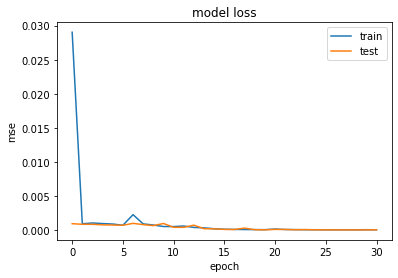

In [366]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [367]:
y_hat = model.predict(X_test)
y_hat = np.squeeze(y_hat)

In [368]:
y_hat = np.array(y_hat, dtype='float')

In [342]:
y_hat

array([0.01506499, 0.02496227, 0.02327828, ..., 0.01525152, 0.05894916,
       0.00319579])

In [374]:
# Defines a function to calculate some performance measures
# Source: https://srdas.github.io/DLBook/DeepLearningWithPython.html#option-pricing
def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = np.mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = np.sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = np.mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = np.sqrt(stats['mse'])/np.mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    plt.rcParams['agg.path.chunksize'] = 100000
    plt.figure(figsize=(10,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual IV',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted IV',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    return stats

Mean Squared Error:       2.6063544273514026e-05
Root Mean Squared Error:  0.0051052467397290436
Mean Absolute Error:      0.002930120523583702
Mean Percent Error:       0.13929870125486432


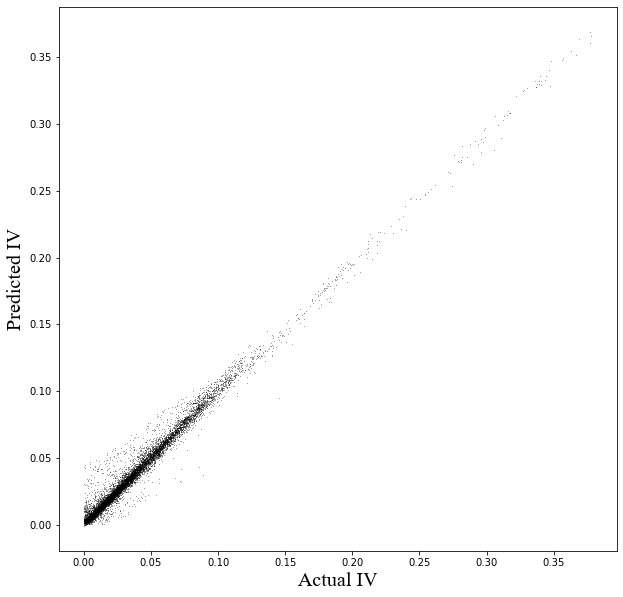

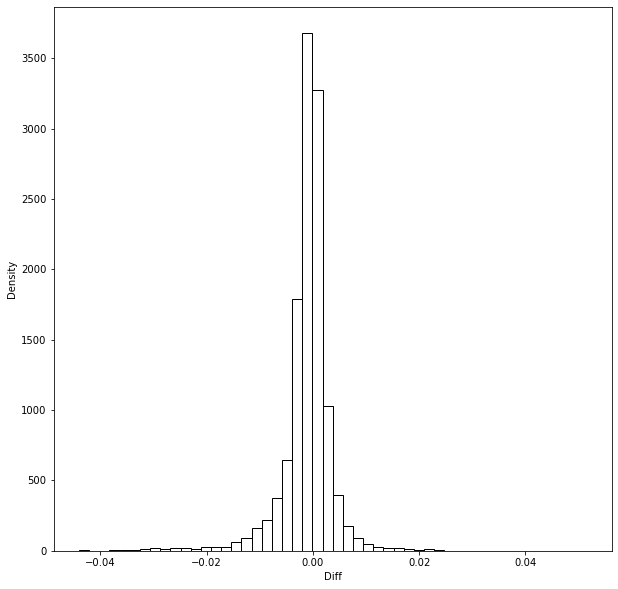

{'diff': 954765     0.000242
 711377     0.002982
 1086810    0.002154
 859684    -0.002975
 1040050   -0.002955
              ...   
 530703     0.002041
 608920    -0.002459
 591292    -0.003862
 462411    -0.001473
 1120191   -0.000852
 Name: imp_vol, Length: 12348, dtype: float64,
 'mse': 2.6063544273514026e-05,
 'rmse': 0.0051052467397290436,
 'mae': 0.002930120523583702,
 'mpe': 0.13929870125486432}

In [375]:
CheckAccuracy(y_test,y_hat)

In [345]:
# plot df - prepare a subset of the test data for plotting
plot_df = X_test.drop(['risk_free_rate', 'sigma'], axis = 1)

In [346]:
plot_df['moneyness'] = plot_df['strike_price'] / plot_df['stock_price']
plot_df['pred_iv'] = y_hat
plot_df['imp_vol'] = y_test.tolist()

In [347]:
plot_df['mae'] = abs(plot_df['imp_vol'] - plot_df['pred_iv'])

In [348]:
plot_df

,stock_price,strike_price,maturity,moneyness,pred_iv,imp_vol,mae
954765,56,36,1.333333,0.642857,0.015065,0.015307,0.000242
711377,52,26,1.750000,0.500000,0.024962,0.027945,0.002982
1086810,58,53,1.666667,0.913793,0.023278,0.025432,0.002154
859684,54,63,1.000000,1.166667,0.028662,0.025687,0.002975
1040050,57,68,0.500000,1.192982,0.072568,0.069612,0.002955
...,...,...,...,...,...,...,...
530703,49,21,1.583333,0.428571,0.006716,0.008757,0.002041
608920,50,44,1.833333,0.880000,0.016793,0.014334,0.002459
591292,50,23,1.833333,0.460000,0.015252,0.011389,0.003862
462411,47,80,1.083333,1.702128,0.058949,0.057476,0.001473


In [349]:
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

def plot_iv_surface(data, x="moneyness", y='maturity', z='iv'):
    """ Plots the IV surface
    """
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection='3d')
    ax.azim = 120
    ax.elev = 13
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

    ax.invert_xaxis()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
    
    surf = ax.plot_trisurf(data[x], data[y], data[z], antialiased=True, cmap = plt.cm.Spectral)
    fig.colorbar(surf, shrink=0.7, aspect=10)
    
    plt.tight_layout()
    
    plt.show()
# Source: https://github.com/svenhsia/Calibrating-Rough-Volatility-Models-with-Deep-Learning/blob/master/Deep-Calibration.ipynb

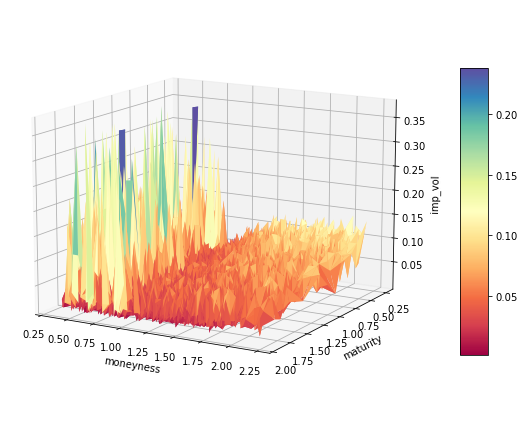

In [350]:
plot_iv_surface(plot_df, z = 'imp_vol')

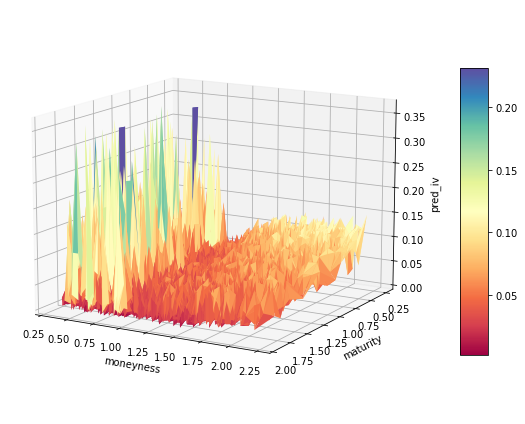

In [351]:
plot_iv_surface(plot_df, z = 'pred_iv')

In [352]:
# Plot iv for new data (i.e. use the model on real data)
stock_price = np.linspace(40, 60, 21)
strike_price = np.linspace(20,90, 21)
maturity = np.linspace(3/12, 2, 21)

stock_price, strike_price, maturity = np.meshgrid(stock_price, strike_price, maturity)

df_iv = pd.DataFrame(columns=train.columns)
df_iv['stock_price'] = stock_price.flatten()
df_iv['strike_price'] = strike_price.flatten()
df_iv['maturity'] = maturity.flatten()
df_iv['risk_free_rate'] = 0.01
df_iv['sigma'] = 0.1

In [353]:
df_iv

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price,imp_vol
0,40.0,20.0,0.2500,0.01,0.1,NaN,NaN,NaN
1,40.0,20.0,0.3375,0.01,0.1,NaN,NaN,NaN
2,40.0,20.0,0.4250,0.01,0.1,NaN,NaN,NaN
3,40.0,20.0,0.5125,0.01,0.1,NaN,NaN,NaN
4,40.0,20.0,0.6000,0.01,0.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9256,60.0,90.0,1.6500,0.01,0.1,NaN,NaN,NaN
9257,60.0,90.0,1.7375,0.01,0.1,NaN,NaN,NaN
9258,60.0,90.0,1.8250,0.01,0.1,NaN,NaN,NaN
9259,60.0,90.0,1.9125,0.01,0.1,NaN,NaN,NaN


In [354]:
df_iv['black_scholes'] = bs_option_value(df_iv['stock_price'], df_iv['strike_price'],
                                               df_iv['maturity'], df_iv['risk_free_rate'],
                                               df_iv['sigma'])

In [355]:
# Add some random noise to the real prices to create the option prices
df_iv["option_price"] = df_iv["black_scholes"] + np.random.normal(1, 0.1)

In [356]:
df_iv['imp_vol'] = df_iv.apply(lambda row: implied_volatility(row['option_price'], row['stock_price'], row['strike_price'],
                                              row['maturity'], row['risk_free_rate'], row['sigma']), axis = 1)

In [357]:
df_iv_2 = df_iv.drop(['black_scholes', 'option_price', 'imp_vol'], axis = 1)

In [358]:
#columns = ["stock_price", 'strike_price', 'maturity', 'risk_free_rate', 'sigma']
#df_iv_scaled, df_iv_scaled_2 = standardize(df_iv, df_iv, columns)

In [359]:
#df_iv_scaled

In [360]:
df_iv['iv_pred'] = model.predict(df_iv_2)

In [361]:
df_iv['moneyness'] = df_iv['strike_price'] / df_iv['stock_price']

In [362]:
df_iv['mae'] = abs(df_iv['imp_vol'] - df_iv['iv_pred'])

In [363]:
df_iv

,stock_price,strike_price,maturity,risk_free_rate,sigma,black_scholes,option_price,imp_vol,iv_pred,moneyness,mae
0,40.0,20.0,0.2500,0.01,0.1,20.049938,21.069326,0.038066,0.038913,0.5,0.000847
1,40.0,20.0,0.3375,0.01,0.1,20.067386,21.086775,0.038095,0.038788,0.5,0.000693
2,40.0,20.0,0.4250,0.01,0.1,20.084820,21.104208,0.038123,0.038662,0.5,0.000539
3,40.0,20.0,0.5125,0.01,0.1,20.102238,21.121626,0.038150,0.038536,0.5,0.000386
4,40.0,20.0,0.6000,0.01,0.1,20.119641,21.139029,0.038178,0.038520,0.5,0.000343
...,...,...,...,...,...,...,...,...,...,...,...
9256,60.0,90.0,1.6500,0.01,0.1,0.003233,1.022621,0.026244,0.020849,1.5,0.005395
9257,60.0,90.0,1.7375,0.01,0.1,0.004454,1.023843,0.026215,0.021253,1.5,0.004962
9258,60.0,90.0,1.8250,0.01,0.1,0.005970,1.025358,0.026179,0.021550,1.5,0.004629
9259,60.0,90.0,1.9125,0.01,0.1,0.007810,1.027199,0.026135,0.021839,1.5,0.004296


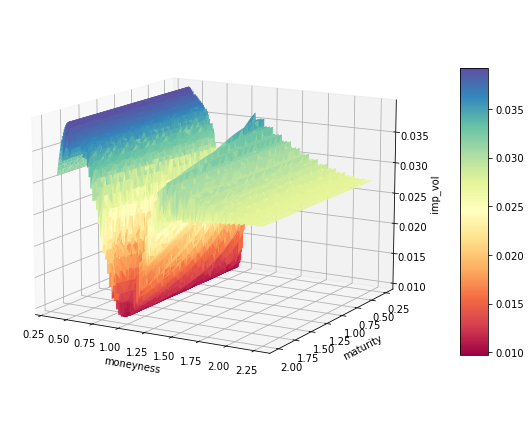

In [364]:
plot_iv_surface(df_iv, z = 'imp_vol')

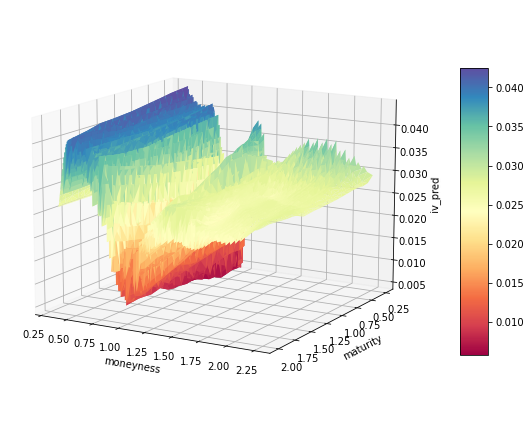

In [365]:
plot_iv_surface(df_iv, z = 'iv_pred')

looking good...